In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [13]:
!gdown --id 1VEB8MPXDnLHSk41lEg5JnGy0d-Ycue8x

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1VEB8MPXDnLHSk41lEg5JnGy0d-Ycue8x
To: /content/monthly-champagne data.xlsx
100% 11.9k/11.9k [00:00<00:00, 11.7MB/s]


In [14]:
df = pd.read_excel(
  'https://drive.google.com/uc?id=1VEB8MPXDnLHSk41lEg5JnGy0d-Ycue8x',
  index_col='Month',
  skipfooter=2,
  parse_dates=True)

In [15]:
df.columns = ['Sales']

In [16]:
df['LogSales'] = np.log(df['Sales'])

In [17]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [18]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df['LogSales'].to_numpy()

T = 12
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (93, 12) Y.shape (93,)


In [19]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [20]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.8682372095558998

In [21]:
lr.score(Xtest, Ytest)

0.9657520752272787

In [22]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False # first T values are not predictable

In [23]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

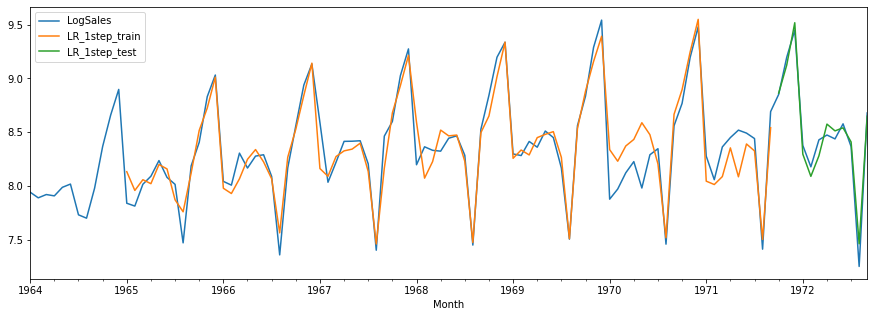

In [24]:
# plot 1-step forecast
df[['LogSales', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

In [25]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = lr.predict(last_x.reshape(1, -1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [26]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

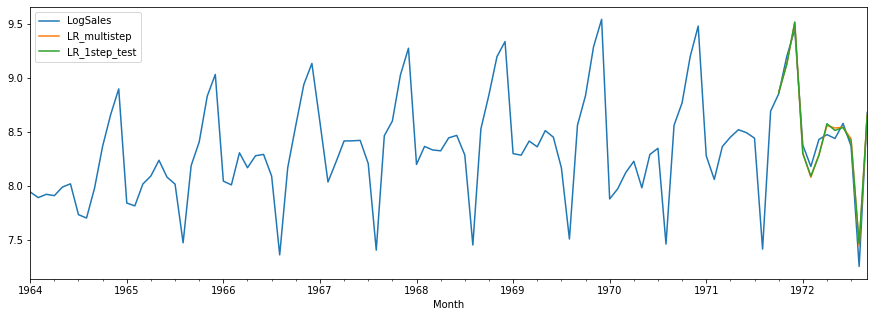

In [27]:
# plot 1-step and multi-step forecast
df[['LogSales', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5));

In [28]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (82, 12) Y.shape (82, 12)


In [29]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [30]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8829262390390559

In [31]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.9595107879158425

In [32]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

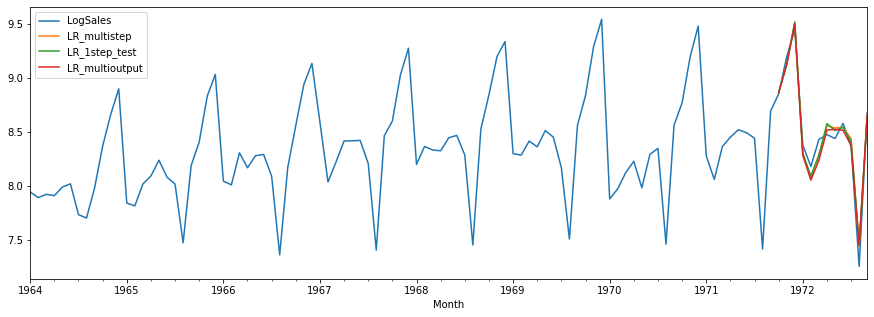

In [33]:
# plot all forecasts
cols = ['LogSales', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15, 5));

In [34]:
# MAPE
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    Ytest, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.009607169373797757
multi-output MAPE: 0.009727020853255894


## Test Other Models

In [35]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step forecast:", name)
  # print("Train R^2:", model.score(Xtrain, Ytrain))
  # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    # update the predictions list
    multistep_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
  
  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
  print("Test MAPE (multi-step):", mape)

  # plot 1-step and multi-step forecast
  cols = [
    'LogSales',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.013188370472848127


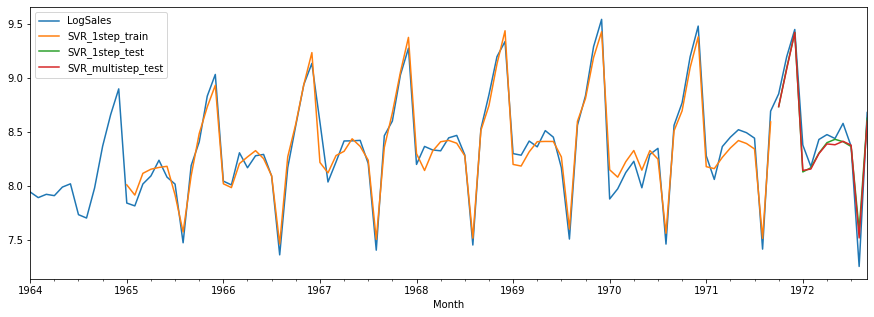

In [36]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.01188682046900793


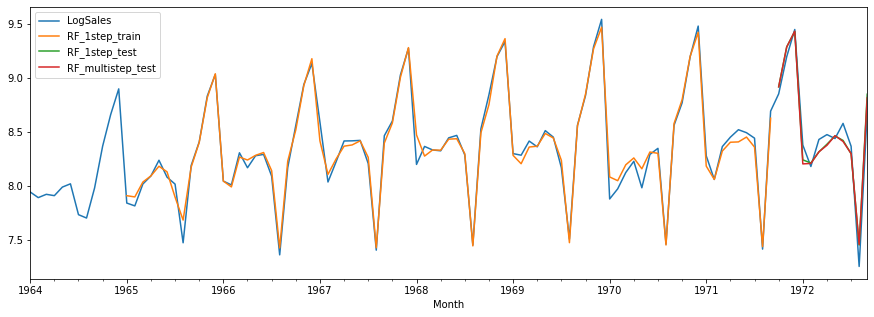

In [37]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [38]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)
  
  # save multi-output forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()

  mape = mean_absolute_percentage_error(
      Ytest, df.loc[test_idx, f'{name}_multioutput'])
  print("Test MAPE (multi-output):", mape)

  # plot all forecasts
  # assume that previous functions have been run
  cols = [
    'LogSales',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]
  df[cols].plot(figsize=(15, 5));

In [39]:
# multi_output_forecast(SVR(), "SVR") # cannot handle multi-output!

Test MAPE (multi-output): 0.01948680662651767


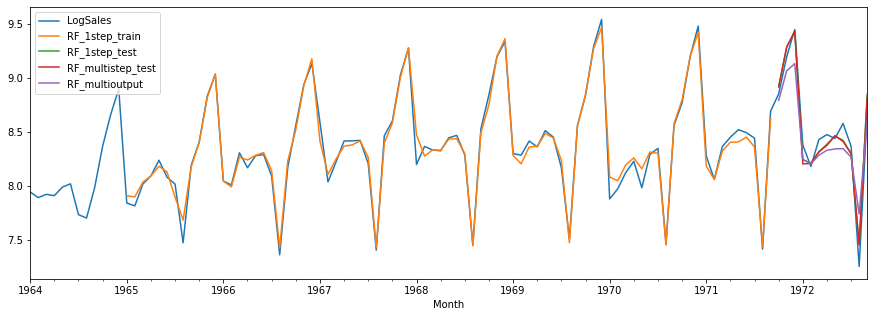

In [40]:
multi_output_forecast(RandomForestRegressor(), "RF")

In [41]:
# Exercise: compute MAPE for non-logged data (i.e. exponentiate predictions)
# Compare with previous models (e.g. ARIMA, ETS)

# Exercise: does differencing help?